In [1]:
import cv2

cv2.__version__

'4.6.0'

# Define functions

In [3]:
import time
from sklearn import manifold
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# TSNE visualization of data with categorical colorization
def TSNE_visu(_data, _category_label, _ax):
    # Create TSNE decomposer
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                         init='random', learning_rate=200, random_state=42)
    # Decompose bag of words features using TNSE
    X_tsne = tsne.fit_transform(_data)

    # Data visualization
    scatter = _ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=_category_label, cmap='Set1')
    _ax.legend(handles=scatter.legend_elements()[0], labels=list(
        set(_category_label)), loc="best", title="Categories", fontsize=15, title_fontsize=15)
    return

def PCA_visu(_data, _category_label, _ax):
    # Create TSNE decomposer
    pca = PCA(n_components=2, svd_solver='full')
    # Decompose bag of words features using TNSE
    X_pca = pca.fit_transform(_data)

    # Data visualization
    scatter = _ax.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=_category_label, cmap='Set1')
    _ax.legend(handles=scatter.legend_elements()[0], labels=list(
        set(_category_label)), loc="best", title="Categories", fontsize=15, title_fontsize=15)
    return

def show_keypoints(_image, _keypoints):
    image_with_keypoints = cv2.drawKeypoints(_image, _keypoints, _image)
    cv2.imshow('test', image_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Load data

In [4]:
import pandas as pd

# Fichier des tweets à récupérer sur :
# https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+prétraitement+textes+images.zip
data_T0 = pd.read_csv(
    "Flipkart/flipkart_com-ecommerce_sample_1050.csv", index_col=['uniq_id'])

data_T = pd.DataFrame(
    data_T0[['image', 'product_category_tree']])

In [5]:
from sklearn import preprocessing

def get_category(_cat_tree):
    categories_list = _cat_tree.replace(
        '["', '').replace('"]', '').split(' >> ')
    return " ".join(categories_list[:1])


data_T['category'] = data_T['product_category_tree'].apply(
    lambda cat_tree: get_category(cat_tree))

data_T['category_label'] = preprocessing.LabelEncoder(
).fit_transform(data_T['category'])

# Function to get images features

In [6]:
import pandas as pd
import cv2
import os


def get_images_features(_folder, _detector_model):
    cpt = 0

    index_ = pd.MultiIndex.from_tuples([], names=['image', 'keypoint'])
    labels_df = pd.DataFrame(columns=['label'])

    # For loop to cross over images in folder
    for fname in os.listdir(folder):
        # Check fname is jpg file
        if not os.path.isfile(os.path.join(folder, fname)) or not fname.endswith('.jpg'):
            continue
        print(cpt,':',fname)
        # Read image with opencv
        img1 = cv2.imread(os.path.join(folder, fname))

        # Keypoints and descriptors detection
        keypoints, descriptors = _detector_model.detectAndCompute(img1, None)
        # Case no keypoint is detected
        if descriptors is None:
            continue
        
        descriptors_selection = descriptors[0:1000]
        
        print(len(descriptors))
        print(len(descriptors_selection))
        # Create multi index containing features index and image index
        features_index = list(range(len(descriptors_selection)))
        img_index = [cpt]*len(descriptors_selection)
        index_ = pd.MultiIndex.from_tuples(
            zip(img_index, features_index), names=['image', 'keypoint'])

        # Create dataframe containing current image features
        current_features_df = pd.DataFrame(
            descriptors_selection, columns=range(len(descriptors_selection[0])), index=index_)
        print(current_features_df.shape)  
        # Concatanate current image features dataframe with  global image features dataframe
        if cpt == 0:
            features_df = current_features_df
        else:
            features_df = pd.concat([features_df, current_features_df], axis=0)

        # Get category label of current image
        label = data_T.loc[data_T['image'] == fname].iloc[0]['category_label']

        # Fill category label dataframe
        labels_df.loc[cpt, 'label'] = label
        cpt = cpt+1
        
    return features_df, labels_df

# Get bag of features with SIFT, SURF, ORB, BRISK

In [7]:
from sklearn.cluster import KMeans
import numpy as np

folder = 'Flipkart/Images/'

def get_bag_of_features(folder, _model):
    features_df, labels_df = get_images_features(folder, _model)
    print(features_df.shape)

    # KMeans
    kmeans = KMeans(n_clusters=200, random_state=0).fit(features_df)

    kmeans_labels_df = pd.DataFrame(kmeans.labels_, index=features_df.index)

    bag_of_features = [list(np.histogram(kmeans_labels_df.loc[cpt, :], bins=9, density=1)[0])
                       for cpt in kmeans_labels_df.index.get_level_values('image').unique()]
    print(len(bag_of_features))

    
    return bag_of_features, labels_df
    

#orb_model = cv2.ORB_create()
#orb_bag_of_features, orb_labels_df = get_bag_of_features(folder, orb_model)

#sift_model = cv2.xfeatures2d.SIFT_create()
#sift_bag_of_features, sift_labels_df = get_bag_of_features(folder, sift_model)

surf_model = cv2.xfeatures2d.SURF_create()
surf_bag_of_features, surf_labels_df = get_bag_of_features(folder, surf_model)

#brisk_model = cv2.BRISK_create()
#brisk_bag_of_features, brisk_labels_df = get_bag_of_features(folder, brisk_model)



error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


In [11]:
from sklearn.metrics import silhouette_score

print('silouhette score : ', silhouette_score(surf_bag_of_features, surf_labels_df.values.ravel()))

silouhette score :  -0.11134472829039967


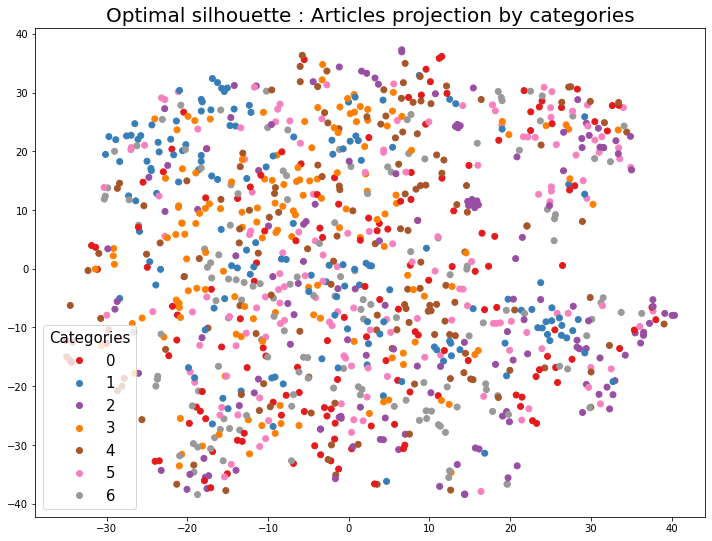

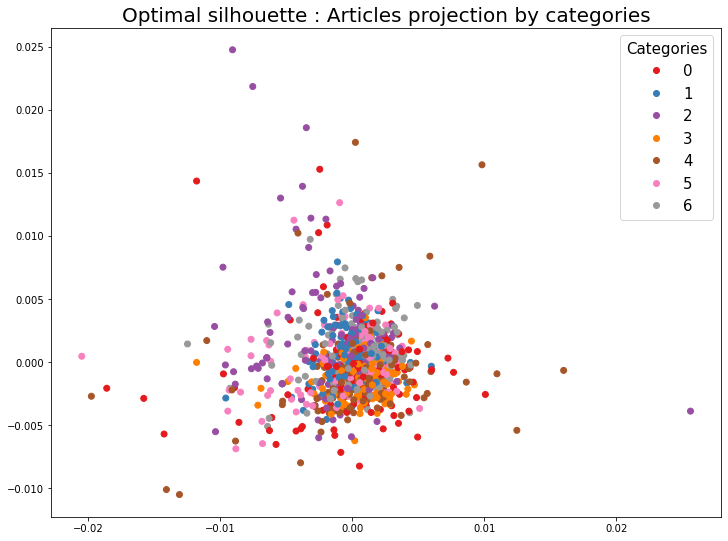

In [9]:
# Display TSNE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
TSNE_visu(surf_bag_of_features, surf_labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()

# Display PCA
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
PCA_visu(surf_bag_of_features, surf_labels_df.values.ravel(), ax)
ax.set_title('Optimal silhouette : Articles projection by categories', fontsize=20)
plt.show()